# SciPy minimizers and constraints

The `Minuit` class can call SciPy minimizers implemented in `scipy.optimize.minimize` as alternatives to the standard Migrad minimizer to minimize the cost function. The SciPy minimizers may perform better or worse on some problems. You can give them a try when you are not satisfied with Migrad.

More importantly, the SciPy minimizers support additional features that Migrad lacks.

* Migrad does not allow one to use an externally computed hessian matrix.
* Migrad does not allow one to use additional constraints of the form $\vec a \leq f(\vec x) \leq \vec b$ in the minimization, where $\vec x$ is the parameter vector of length $m$, $f$ is an arbitrary function $\mathcal{R}^m \rightarrow \mathcal{R}^k$ and $\vec a, \vec b$ are vector bounds with length $k$.

SciPy comes with a variety of minimization algorithms and some of them support these features. The ability to use constraints is interesting for HEP applications. In particular, it allows us to ensure that a pdf as a function of the parameters is always positive. This can be ensured sometimes with suitable limits on the parameters, but not always.

We demonstrate this on a common example of fit of an additive model with a signal and background pdf.

In [1]:
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
import numpy as np
from numba_stats import norm_pdf, norm_cdf
import matplotlib.pyplot as plt
from scipy.interpolate import BPoly
from IPython.display import display

The signal pdf is a Gaussian, the background is modelled with second degree Bernstein polynomials. We perform an extended maximum likelihood fit, where the full density model is given by the sum of the signal and background component.

In [2]:
xrange = (0, 1)


def model(x, b0, b1, b2, sig, mu, sigma):
    bc = np.array((b0, b1, b2))[:, np.newaxis]
    b = BPoly(bc, xrange)
    bint = b.integrate(*xrange)
    sint = sig * np.diff(norm_cdf(xrange, mu, sigma))[0]
    return bint + sint, b(x) + sig * norm_pdf(x, mu, sigma)

In searches for rare decays, it is common to fit models like this to small simulated samples that contain only background, to calculate the distribution of some test statistic (usually the likelihood ratio of S+B and B-only hypotheses). Here, for simplicity, we use the signal amplitude itself as the test statistic.

We run one such fit. The mean and width of the Gaussian are fixed, only the signal amplitude and the background parameters are varied.

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -181.3                     │              Nfcn = 96               │
│ EDM = 1.83e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b0    │    16     │    17     │            │            │    0    │         │       │
│ 1 │ b1    │    85     │    35     │            │            │    0    │         │       │
│ 2 │ b2    │    16     │    16     │            │            │    0    │         │       │
│ 3 │ sig   │   -4.0    │    2.7    │            │            │         │         │       │
│ 4 │ mu    │   0.500   │   0.005   │            │            │         │         │  yes  │
│ 5 │ sigma │  50.0e-3  │  0.5e-3   │            │            │         │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────┐
│       │       b0       b1       b2      sig       mu    sigma │
├───────┼───────────────────────────────────────────────────────┤
│    b0 │      306     -412      110     15.1        0        0 │
│    b1 │     -412 1.21e+03     -366      -62        0        0 │
│    b2 │      110     -366      266     13.4        0        0 │
│   sig │     15.1      -62     13.4     7.28        0        0 │
│    mu │        0        0        0        0        0        0 │
│ sigma │        0        0        0        0        0        0 │
└───────┴───────────────────────────────────────────────────────┘

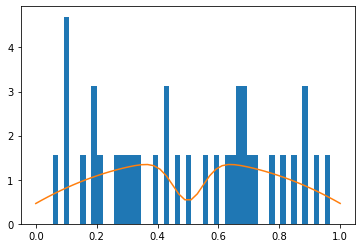

In [3]:
rng = np.random.default_rng(2)
x = rng.uniform(0, 1, size=35)

cost = ExtendedUnbinnedNLL(x, model)
n = len(x)
m = Minuit(cost, b0=n, b1=n, b2=n, sig=0, mu=0.5, sigma=0.05)
m.print_level = 0
m.limits["b0", "b1", "b2"] = (0, None)
m.fixed["mu", "sigma"] = True
display(m.migrad())

plt.hist(x, bins=50, density=True)
xm = np.linspace(0, 1)
yint, ym = model(xm, *m.values)
plt.plot(xm, ym / yint);

In this example, the signal amplitude came out negative. This happens if the background has an underfluctuation where the signal is expected. This is not an issue if the sum of signal and background density is still positive everywhere where we evaluate it. As long as the total density is positive, individual components are allowed to be negative.

There are, however, no principle restrictions in this example that prevent the sum of signal and background from becoming negative for some toy data sets. When that happens, the fit will fail, since the total density cannot mathematically become negative.

If this happens anyway, the fit will fail since taking logarithm of a negative number will cause havoc.

## Migrad fit on toys

We apply the fit many times on randomly sampled background-only data to observe this.

In [4]:
rng = np.random.default_rng(1)

sigs_migrad = []
for itry in range(200):
    cost.data = rng.uniform(0, 1, size=len(cost.data))
    m.reset()
    m.migrad()
    sigs_migrad.append(m.values["sig"] if m.valid else np.nan)

print(np.sum(np.isnan(sigs_migrad)), "failed")
m # show last result

27 failed


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -179.8                     │              Nfcn = 79               │
│ EDM = 6.43e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b0    │    24     │    17     │            │            │    0    │         │       │
│ 1 │ b1    │    67     │    34     │            │            │    0    │         │       │
│ 2 │ b2    │    20     │    17     │            │            │    0    │         │       │
│ 3 │ sig   │   -1.8    │    2.9    │            │            │         │         │       │
│ 4 │ mu    │   0.500   │   0.005   │            │            │         │         │  yes  │
│ 5 │ sigma │  50.0e-3  │  0.5e-3   │            │            │         │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────┐
│       │       b0       b1       b2      sig       mu    sigma │
├───────┼───────────────────────────────────────────────────────┤
│    b0 │      289     -370      113     13.5        0        0 │
│    b1 │     -370 1.14e+03     -400    -58.4        0        0 │
│    b2 │      113     -400      305     13.9        0        0 │
│   sig │     13.5    -58.4     13.9     8.59        0        0 │
│    mu │        0        0        0        0        0        0 │
│ sigma │        0        0        0        0        0        0 │
└───────┴───────────────────────────────────────────────────────┘

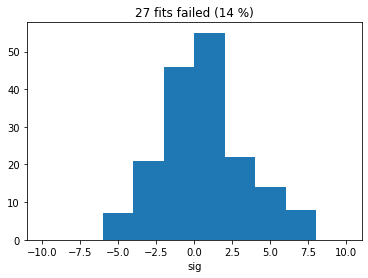

In [5]:
nfailed = np.sum(np.isnan(sigs_migrad))
plt.title(f"{nfailed} fits failed ({nfailed / len(sigs_migrad) * 100:.0f} %)")
plt.hist(sigs_migrad, bins=10, range=(-10, 10))
plt.xlabel("sig");

The distribution of the signal amplitude looks fairly gaussian which is good, but the fit failed to converge in a few cases due to the problem just described. Simply discarding these cases is not acceptable, it would distort conclusions drawn from the distribution of the test statistic, which is commonly needed to set limits or to compute the p-value for an observed amplitude.

We can repair this by placing a limit on the signal amplitude. This is a suitable solution, although it will bias the signal amplitude and change the shape of the distribution of the test statistic. 

An alternative is to perform a constrained minimization, which allows us to directly add a condition to the fit that the model density must be positive at each data point. We merely need to replace the call `m.migrad` with the call `m.scipy` and pass the (non-linear) constraint. An appropriate algorithm is automatically selected which performs a constrained minimization. The SciPy minimizers are fully integrated into Minuit, which means that Minuit computes an EDM value for the minimum and parameter uncertainties.

## SciPy constrained fit on toys 

We run SciPy with the constraint on the same simulated samples on which we ran Migrad before.

In [6]:
from scipy.optimize import NonlinearConstraint

rng = np.random.default_rng(1)

sigs_constrained = []
for itry in range(200):
    cost.data = rng.uniform(0, 1, size=len(cost.data))
    m.reset()
    # constraint to ensure that the density is positive at all values of x
    m.scipy(constraints=NonlinearConstraint(lambda *par: model(x, *par)[1], 0, np.inf))
    sigs_constrained.append(m.values["sig"] if m.valid else np.nan)

print(np.sum(np.isnan(sigs_constrained)), "failed")
m # show last result

0 failed


┌─────────────────────────────────────────────────────────────────────────┐
│                             SciPy[SLSQP]                                │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -179.8                     │              Nfcn = 148              │
│ EDM = 1.65e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b0    │    24     │    17     │            │            │    0    │         │       │
│ 1 │ b1    │    67     │    32     │            │            │    0    │         │       │
│ 2 │ b2    │    20     │    17     │            │            │    0    │         │       │
│ 3 │ sig   │   -1.8    │    2.8    │            │            │         │         │       │
│ 4 │ mu    │   0.500   │   0.005   │            │            │         │         │  yes  │
│ 5 │ sigma │  50.0e-3  │  0.5e-3   │            │            │         │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────┐
│       │       b0       b1       b2      sig       mu    sigma │
├───────┼───────────────────────────────────────────────────────┤
│    b0 │      279     -335      103     10.5        0        0 │
│    b1 │     -335 1.01e+03     -363    -46.3        0        0 │
│    b2 │      103     -363      294     10.7        0        0 │
│   sig │     10.5    -46.3     10.7     7.59        0        0 │
│    mu │        0        0        0        0        0        0 │
│ sigma │        0        0        0        0        0        0 │
└───────┴───────────────────────────────────────────────────────┘

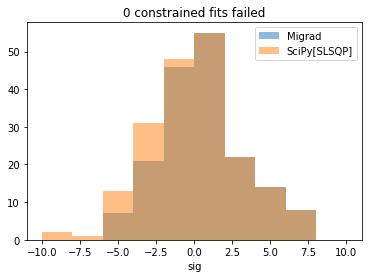

In [7]:
plt.title(f"{np.sum(np.isnan(sigs_constrained))} constrained fits failed")
plt.hist(sigs_migrad, alpha=0.5, bins=10, range=(-10, 10), label="Migrad")
plt.hist(sigs_constrained, alpha=0.5, bins=10, range=(-10, 10), label=m.fmin.algorithm)
plt.xlabel("sig")
plt.legend();

There are no failures this time. 

For sig > 0, the distributions are identical in this example, as theoretically expected. In practice, there can be small bin migration effects due to finite precision of numerical algorithms. These are not of concern.

Important are the differences for sig < 0, where Migrad did not converge in a few cases and where therefore samples are missing. Those missing samples are recovered in the distribution produced by the constrained fit.

This demonstrates that it is important to not discard failed fits, as this will in general distort the distribution of the test statistic.

## Bonus: unconstrained SciPy fit

The issues we describe here are of a principal mathematical nature. We should not expect that an unconstrained minimiser from SciPy does better than Migrad, but let's test this assumption. The minimiser that SciPy uses when only box constraints are used is the L-BFGS-B method which is roughly comparable to Migrad. Let us see how well this algorithm does on the same toy samples.

In [8]:
rng = np.random.default_rng(1)

sigs_bfgs = []
for itry in range(200):
    cost.data = rng.uniform(0, 1, size=len(cost.data))
    m.reset()
    m.scipy()
    sigs_bfgs.append(m.values["sig"] if m.valid else np.nan)

print(np.sum(np.isnan(sigs_bfgs)), "failed")
m # show last result

2 failed


┌─────────────────────────────────────────────────────────────────────────┐
│                           SciPy[L-BFGS-B]                               │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -179.8                     │              Nfcn = 116              │
│ EDM = 4.18e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b0    │    24     │    16     │            │            │    0    │         │       │
│ 1 │ b1    │    67     │    30     │            │            │    0    │         │       │
│ 2 │ b2    │    20     │    17     │            │            │    0    │         │       │
│ 3 │ sig   │   -1.8    │    2.7    │            │            │         │         │       │
│ 4 │ mu    │   0.500   │   0.005   │            │            │         │         │  yes  │
│ 5 │ sigma │  50.0e-3  │  0.5e-3   │            │            │         │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────┐
│       │    b0    b1    b2   sig    mu sigma │
├───────┼─────────────────────────────────────┤
│    b0 │   261  -290  84.8  8.16     0     0 │
│    b1 │  -290   904  -318 -40.5     0     0 │
│    b2 │  84.8  -318   276  8.36     0     0 │
│   sig │  8.16 -40.5  8.36  7.29     0     0 │
│    mu │     0     0     0     0     0     0 │
│ sigma │     0     0     0     0     0     0 │
└───────┴─────────────────────────────────────┘

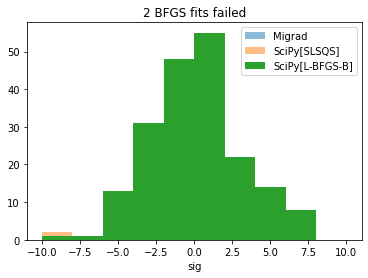

In [9]:
plt.title(f"{np.sum(np.isnan(sigs_bfgs))} BFGS fits failed")
plt.hist(sigs_migrad, alpha=0.5, bins=10, range=(-10, 10), label="Migrad")
plt.hist(sigs_constrained, alpha=0.5, bins=10, range=(-10, 10), label="SciPy[SLSQS]")
plt.hist(sigs_bfgs, bins=10, range=(-10, 10), label=m.fmin.algorithm)
plt.xlabel("sig")
plt.legend();

In this example, the BFGS method actually failed much less than Migrad, but it still fails in some cases, while the constrained fit did not fail at all.

## Speed comparison

Since constrained fits are so useful, should you use them?

One of the caveats of constrained fits is that they are more computationally expensive. Satisfying extra constrains slows down convergence. Let's compare the speed of the three tested minimisers. We set the strategy to 0, to avoid computing the Hessian matrix automatically, since we want to measure only the time used by the minimiser.

In [10]:
m.strategy = 0

In [11]:
%timeit -n3 m.reset(); m.migrad()

6.62 ms ± 819 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [12]:
%timeit -n3 m.reset(); m.scipy()

14 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [13]:
%timeit -n3 m.reset(); m.scipy(constraints=NonlinearConstraint(lambda *par: model(x, *par)[1], 0, np.inf))

42 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


Migrad is the fastest, followed by BFGS, which is a factor 1.8 slower. The constrained fit is about a factor 6 slower on this computer.

The constrained fit is much slower as expected, since it has to do more work. That Migrad is faster than BFGS is not so obvious and it is not clear whether that result holds in general.

However, Migrad is comparably fast because of its smart stopping criterion. Migrad stops the fit already, when the variation of the fitted parameters become small compared to their uncertainties. Migrad was explicitly designed for statistical fits, where the cost function is a log-likelihood or least-squares function. By default it assumes that it is doing a statistical fit and stops the fit as soon as the improvements become negligible compared to the uncertainty.

The SciPy minimisers do not expect the cost function to have some statistical meaning. Therefore, they tend to optimise until they hit the limits of machine precision. This is the main reason why the BFGS method is slower.

We can force Migrad to do something similar by setting the tolerance to a tiny value.

In [14]:
m.tol = 1e-20

In [15]:
%timeit -n3 m.reset(); m.migrad()

12 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


Now the time required is similar to BFGS (although Migrad is still a bit faster).